# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://ramp.r0h.eu/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [2]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [3]:
# !pip install -U seaborn  # if you don't have it, or pip3 for python3

In [4]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

First we load `problem.py` that parameterizes the challenge. It contains some objects taken off the shelf from `ramp-workflow` (e.g., `Predictions` type, scores, and data reader). 

In [5]:
problem = imp.load_source('', 'problem.py') #problem is a module with different methods

`get_train_data` loads the training data and returns an `pandas` object (input) and a `np.array` object (output).

In [6]:
X_df, y_array = problem.get_train_data() #get_train_data() is one of those methods
X_train = X_df.copy()
X_train["passengers"] = y_array


## Data exploration

In [7]:
print(min(X_df['DateOfDeparture']))
print(max(X_df['DateOfDeparture']))

2011-09-01
2013-03-05


In [8]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,passengers
0,2012-06-19,ORD,DFW,12.875000,9.812647,12.331296
1,2012-09-10,LAS,DEN,14.285714,9.466734,10.775182
2,2012-10-05,DEN,LAX,10.863636,9.035883,11.083177
3,2011-10-09,ATL,ORD,11.480000,7.990202,11.169268
4,2012-02-21,DEN,SFO,11.450000,9.517159,11.269364


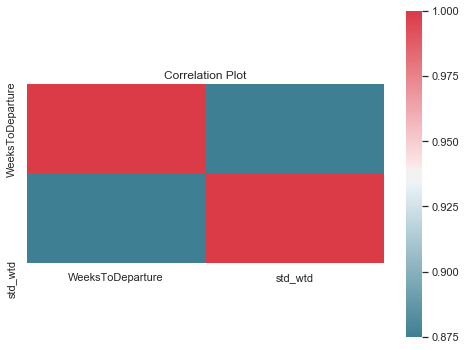

In [9]:
cor = X_df.corr(method='pearson')
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

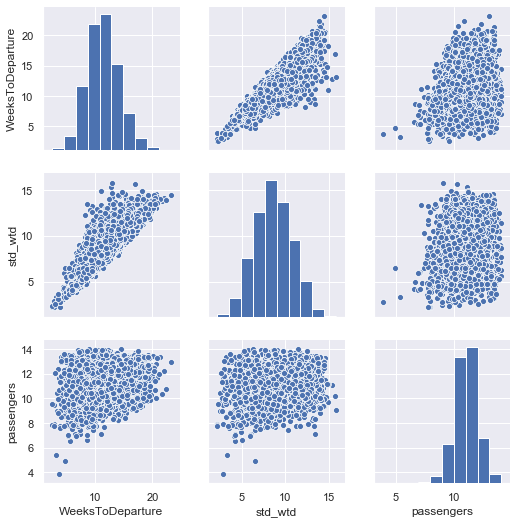

In [10]:
sns.pairplot(X_train)

In [11]:
X_df['Departure'].unique() #Return Index with unique values from an Index object.

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

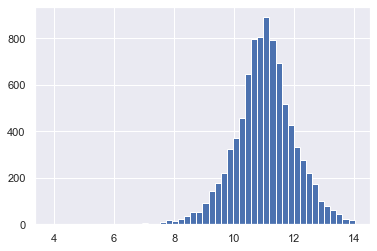

In [12]:
plt.hist(y_array, bins=50);

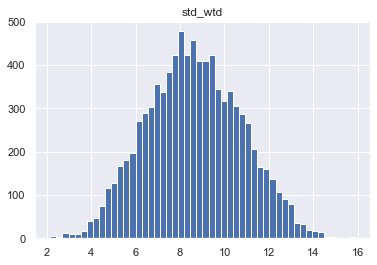

In [13]:
X_df.hist('std_wtd', bins=50);

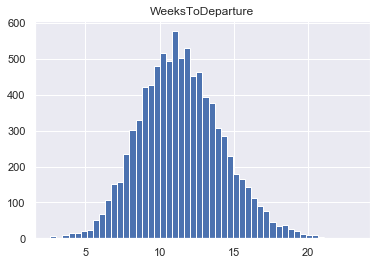

In [14]:
X_df.hist('WeeksToDeparture', bins=50);


In [15]:
X_df.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [16]:
X_df.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
std_wtd             float64
dtype: object

In [17]:
X_df.shape

(8902, 5)

In [18]:
print(y_array.mean())
print(y_array.std())

10.99904767212102
0.9938894125318564


### outliers 

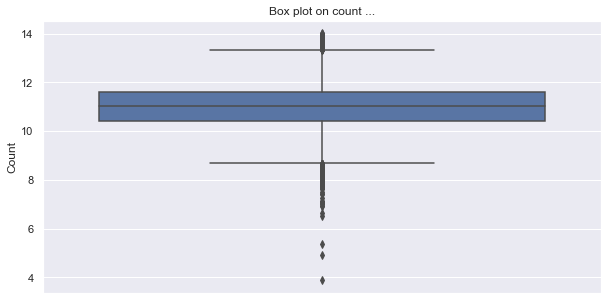

In [115]:
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(data=X_df, y= y_array, orient="v")
ax.set(ylabel='Count', title="Box plot on count ...")
plt.show()

In [ ]:
#remove the outliers

## Time series analysis/grouped by month


(array([734442., 734503., 734563., 734624., 734685., 734747., 734808.,
        734869., 734928.]), <a list of 9 Text xticklabel objects>)

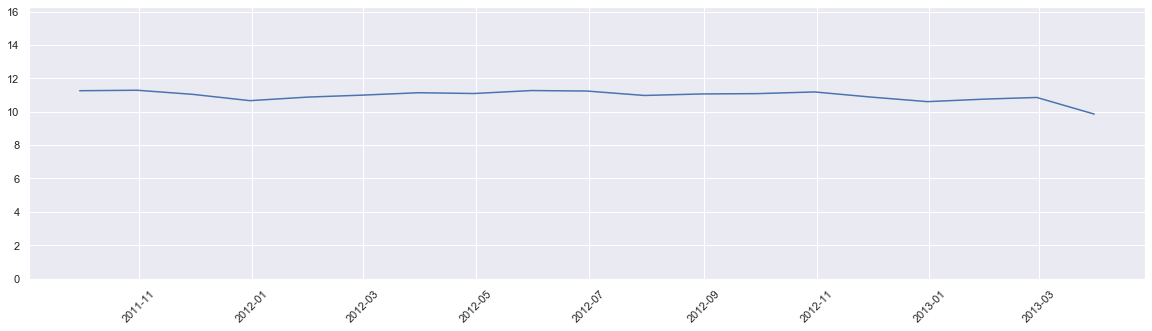

In [19]:
X_train2 = X_train.copy()
X_train2['DateOfDeparture'] = pd.to_datetime(X_train2['DateOfDeparture'])
X_train2 = X_train2.set_index('DateOfDeparture')
X_train2 = X_train2.resample('M').mean()

x = X_train2.index
y = X_train2['passengers']
plt.figure(figsize=(20, 5))
plt.ylim(0, max(y)+5)
plt.plot(x, y)
plt.xticks(label=X_train2.index,rotation=45)


DateOfDeparture
2011-09-30    112.558782
2011-10-31    112.838275
2011-11-30    110.386921
2011-12-31    106.601587
2012-01-31    108.731617
2012-02-29    109.880673
2012-03-31    111.348221
2012-04-30    110.886360
2012-05-31    112.656022
2012-06-30    112.362777
2012-07-31    109.712893
2012-08-31    110.620581
2012-09-30    110.818076
2012-10-31    111.818492
2012-11-30    108.784431
2012-12-31    106.010490
2013-01-31    107.536550
2013-02-28    108.518081
2013-03-31     98.560502
Freq: M, Name: passengers, dtype: float64


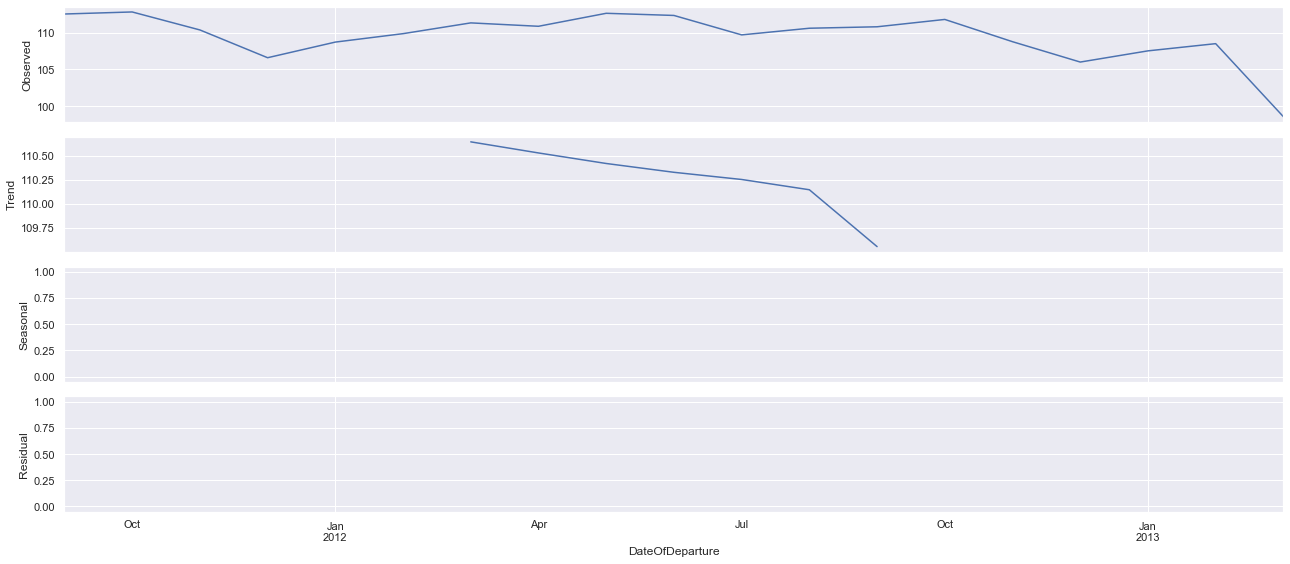

In [20]:
import statsmodels.api as sm
time_serie = X_train2['passengers']*10
print(time_serie)
decomposition = sm.tsa.seasonal_decompose(time_serie, model='multiplicati')

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()



## Mean Encoding

In [21]:
X_mean_encoding = X_df.copy()

## External data exploration

### external_data.csv

In [84]:
external_data = pd.read_csv('data/external_data.csv')
external_data.head(10)



,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149
5,2011-09-06,ATL,24,19,14,22,15,13,90,87,84,1011,1006,998,16,12,4,47,18,56.0,1.52,8,Rain,212
6,2011-09-07,ATL,21,18,14,14,14,13,93,81,68,1016,1014,1011,16,13,2,23,13,32.0,T,8,NaN,297
7,2011-09-08,ATL,23,19,14,14,13,12,87,70,53,1015,1014,1013,16,16,16,27,15,32.0,0.00,5,NaN,322
8,2011-09-09,ATL,27,21,14,13,12,11,93,65,36,1015,1014,1013,16,16,16,26,11,35.0,0.00,1,NaN,302
9,2011-09-10,ATL,29,22,14,13,11,7,84,56,28,1019,1016,1015,16,16,16,21,9,32.0,0.00,0,NaN,321


In [23]:
X_train_merge = X_train.merge(ext_data_filtered, how='left', left_on=['DateOfDeparture', 'Arrival'], right_on=['Date', 'AirPort'])
X_train_merge

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,passengers,Date,AirPort,Mean TemperatureC,Precipitationmm,CloudCover
0,2012-06-19,ORD,DFW,12.875000,9.812647,12.331296,2012-06-19,DFW,29,0.00,5
1,2012-09-10,LAS,DEN,14.285714,9.466734,10.775182,2012-09-10,DEN,25,0.00,3
2,2012-10-05,DEN,LAX,10.863636,9.035883,11.083177,2012-10-05,LAX,19,0.00,5
3,2011-10-09,ATL,ORD,11.480000,7.990202,11.169268,2011-10-09,ORD,19,0.00,1
4,2012-02-21,DEN,SFO,11.450000,9.517159,11.269364,2012-02-21,SFO,12,0.00,7
...,...,...,...,...,...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,10.427055,2011-10-02,ATL,14,0.00,0
8898,2012-09-25,DFW,ORD,12.772727,10.641034,12.201552,2012-09-25,ORD,17,0.00,3
8899,2012-01-19,SFO,LAS,11.047619,7.908705,10.508746,2012-01-19,LAS,8,0.00,6
8900,2013-02-03,ORD,PHL,6.076923,4.030334,10.174042,2013-02-03,PHL,-1,0.25,7


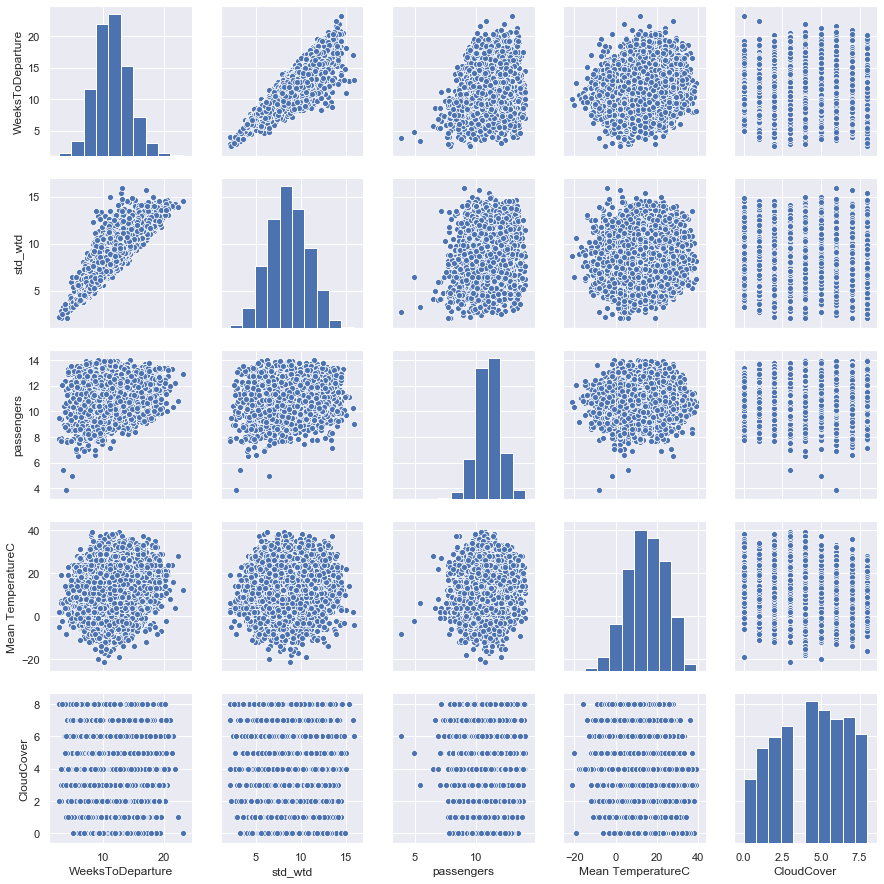

In [24]:
sns.pairplot(X_train_merge)

### IATA_US_CODES.csv

In [93]:
iata = pd.read_csv('data/IATA_US_CODES.csv')
iata.head()

,Rank_2018,Airports (large hubs),IATA Code,Major city served,State,2018,2017,2016,2015
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732"
1,2,Los Angeles International Airport,LAX,Los Angeles,CA,"42,626,783","41,232,432","39,636,042","36,351,226"
2,3,O'Hare International Airport,ORD,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
3,4,Dallas/Fort Worth International Airport,DFW,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832"
4,5,Denver International Airport,DEN,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043"


## Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [25]:

X_encoded = X_df.copy()

#One hot encoding of departure/arrival using pd.dummies
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d')) 
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
X_encoded = X_encoded.drop('Departure', axis=1)
X_encoded = X_encoded.drop('Arrival', axis=1)

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

#We one hot encode all those
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

In [26]:
X_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
8897,2011-10-02,9.263158,7.316967,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,10,2,6,39,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,2012-09-25,12.772727,10.641034,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2012,9,25,1,39,15608,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,2012-01-19,11.047619,7.908705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2012,1,19,3,3,15358,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8900,2013-02-03,6.076923,4.030334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,2,3,6,5,15739,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8901,2011-11-26,9.526316,6.167733,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,11,26,5,47,15304,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


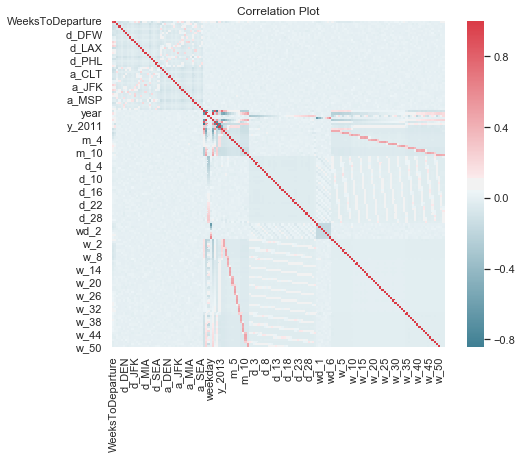

In [27]:
cor = X_encoded.corr(method='pearson')
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

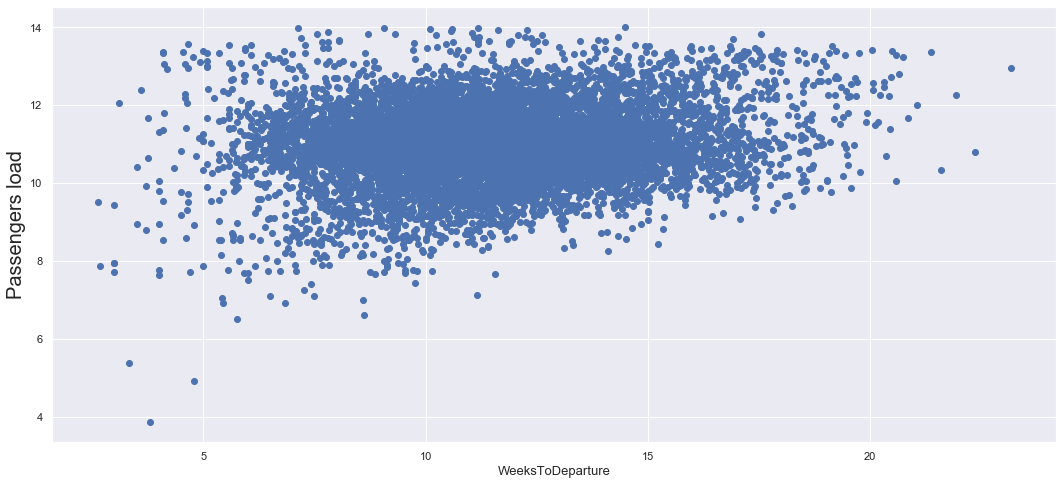

In [28]:
fig, ax = plt.subplots()
ax.scatter(x = X_encoded['WeeksToDeparture'], y = y_array)
plt.ylabel('Passengers load', fontsize=20)
plt.xlabel('WeeksToDeparture', fontsize=13)
plt.show()

### A linear regressor baseline

We drop the target column and the original data column.

In [29]:
features = X_encoded.drop(['DateOfDeparture'], axis=1)
X_columns = features.columns
X_array = features.values

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_array, test_size=0.2, random_state=0)

In [31]:
print(X_train)
print(y_train)

[[12.16        9.33488082  0.         ...  0.          0.
   0.        ]
 [ 9.10526316  5.82041175  0.         ...  0.          0.
   0.        ]
 [10.52631579  8.8466467   0.         ...  0.          0.
   0.        ]
 ...
 [14.91666667 13.06144897  0.         ...  0.          0.
   0.        ]
 [10.47619048  7.22923957  1.         ...  0.          0.
   0.        ]
 [12.17391304  8.54215309  0.         ...  0.          0.
   0.        ]]
[10.59973847 10.91956718 10.68649717 ... 11.01843144 11.30011786
  9.52246452]


It gives us a pretty nice improvement above baseline

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(
    reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6298 +/- 0.0059


In [33]:
#is this good ? Compare it to the dummy classifier:
#10.99904767212102
#0.9938894125318564

In [34]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
reg.coef_

array([ 1.25049568e-01, -7.74138325e-02, -7.48549102e+08, -7.48549103e+08,
       -7.48549103e+08, -7.48549103e+08, -7.48549103e+08, -7.48549103e+08,
       -7.48549103e+08, -7.48549104e+08, -7.48549102e+08, -7.48549103e+08,
       -7.48549102e+08, -7.48549102e+08, -7.48549103e+08, -7.48549104e+08,
       -7.48549103e+08, -7.48549102e+08, -7.48549103e+08, -7.48549103e+08,
       -7.48549103e+08, -7.48549103e+08, -1.64926334e+05, -1.64926714e+05,
       -1.64927209e+05, -1.64926679e+05, -1.64926527e+05, -1.64927274e+05,
       -1.64926923e+05, -1.64927416e+05, -1.64925855e+05, -1.64927117e+05,
       -1.64926117e+05, -1.64925769e+05, -1.64927004e+05, -1.64927418e+05,
       -1.64926775e+05, -1.64926019e+05, -1.64926716e+05, -1.64927025e+05,
       -1.64926945e+05, -1.64926294e+05,  4.17547128e+07,  5.09693467e+06,
       -5.15683515e+05,  1.52246395e+07,  1.41326442e+05,  9.22085822e-01,
        6.92168088e+07,  2.74617584e+07, -1.42932921e+07,  2.94034548e+06,
       -2.15661824e+06, -

Exercise: Visualize the coefficients, try to make sense of them.

## Random Forests

In [36]:
%%time
from sklearn.ensemble import RandomForestRegressor

n_estimators = 500
max_depth = 50
max_features = 10
reg = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

scores = cross_val_score(
    reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)


print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.5804 +/- 0.0159
CPU times: user 122 ms, sys: 96 ms, total: 218 ms
Wall time: 12.3 s


## Random Forests using cross validation and GridSearch

## Variable importances

In [37]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [38]:
len(X_columns)

153

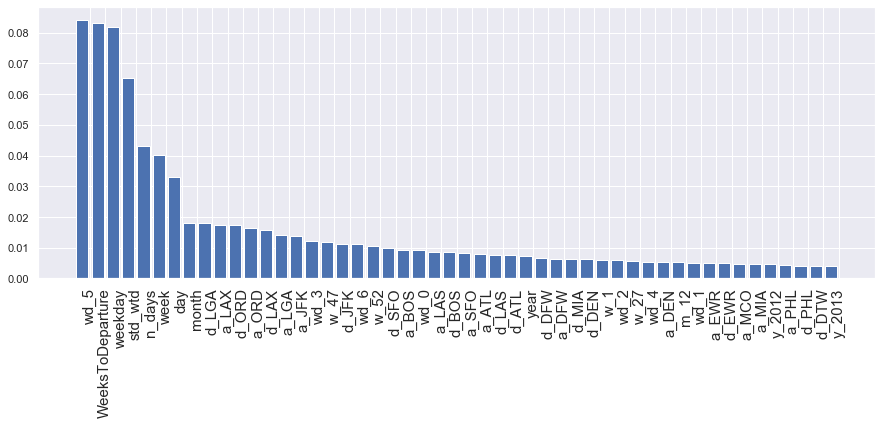

In [39]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);
#plots showing how important each column is in the prediction

## Building predictive models



The feature extractor implements a single <code>transform</code> function. It receives the full pandas object X_df (without the labels). It should produce a numpy array representing the features extracted. If you want to use the (training) labels to save some state of the feature extractor, you can do it in the fit function.

The starting kit feature extractor shows you how to join your data to external data. You will have the possibility to submit a single external csv for each of your submission (so if you have several data sets, you first have to do the join offline, and save it as a csv). In this case it is whether data, joined to the database on the <code>DateOfDeparture</code> and <code>Arrival</code> fields. Attention: when you join the data, make sure that the <b><font color=red>order</font> of the rows in the data frame does not change</b>.

In [40]:
#### Mean encoding function
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

# Feature extractor test place

## Preprocessing function

In [96]:
import os

def transform(X_df):
    X_encoded = X_df.copy()

    __file__ = 'submissions/starting_kit/'
    path = os.path.dirname(__file__)
    data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})

    X_encoded = pd.merge(
        X_encoded, X_weather, how='left',
        left_on=['DateOfDeparture', 'Arrival'],
        right_on=['DateOfDeparture', 'Arrival'],
        sort=False)

    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['Departure'], prefix='d'))
    X_encoded = X_encoded.join(
        pd.get_dummies(X_encoded['Arrival'], prefix='a'))
    X_encoded = X_encoded.drop('Departure', axis=1)
    X_encoded = X_encoded.drop('Arrival', axis=1)



    X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 5 == 1).astype(float)
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

    #We one hot encode all those
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
    return X_encoded



## Split Train/Test Data

In [97]:
X_train = transform(X_df)
columns = X_train.columns
X_train

,WeeksToDeparture,std_wtd,Max TemperatureC,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,Weekend,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,9.812647,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2012,6,19,1,25,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,33,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2012,9,10,0,37,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,22,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,2012,10,5,4,40,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,2011,10,9,6,40,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,9.517159,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,2012,2,21,1,8,15391,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,9.263158,7.316967,20,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2011,10,2,6,39,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,12.772727,10.641034,25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,2012,9,25,1,39,15608,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,11.047619,7.908705,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,2012,1,19,3,3,15358,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [98]:
X_train = X_train.values
y_train = y_array.copy()

X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import mean_squared_error

## RandomForestRegressor

In [100]:
clf = RandomForestRegressor(
            n_estimators=600, max_depth=110, max_features='sqrt',
             min_samples_split=10, min_samples_leaf=1, bootstrap=True)

In [101]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [102]:
y_pred_train = clf.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.38616851206439207


In [103]:
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), columns), 
             reverse=True))

Features sorted by their score:
[(0.0937, 'wd_5'), (0.0786, 'weekday'), (0.0693, 'WeeksToDeparture'), (0.0602, 'Weekend'), (0.0443, 'std_wtd'), (0.0418, 'week'), (0.0406, 'n_days'), (0.0304, 'Max TemperatureC'), (0.0269, 'day'), (0.0203, 'd_LGA'), (0.0178, 'd_ORD'), (0.0171, 'a_ORD'), (0.0167, 'd_LAX'), (0.0166, 'a_LAX'), (0.0161, 'wd_6'), (0.0156, 'month'), (0.0146, 'a_LGA'), (0.0145, 'a_JFK'), (0.0138, 'w_47'), (0.0124, 'd_JFK'), (0.0123, 'w_52'), (0.0103, 'wd_3'), (0.0083, 'a_LAS'), (0.0082, 'd_LAS'), (0.008, 'd_SFO'), (0.0078, 'd_BOS'), (0.0076, 'w_1'), (0.0071, 'wd_0'), (0.0071, 'a_BOS'), (0.0066, 'w_27'), (0.0064, 'a_SFO'), (0.0061, 'd_MIA'), (0.006, 'year'), (0.0059, 'm_12'), (0.0055, 'd_DEN'), (0.0051, 'd_ATL'), (0.0049, 'a_DFW'), (0.0047, 'd_DFW'), (0.0046, 'a_ATL'), (0.0045, 'y_2013'), (0.0043, 'a_DEN'), (0.0042, 'a_MIA'), (0.004, 'd_EWR'), (0.0039, 'wd_1'), (0.0039, 'd_PHX'), (0.0039, 'a_MCO'), (0.0037, 'wd_4'), (0.0036, 'd_DTW'), (0.0036, 'a_IAH'), (0.0036, 'a_EWR'), (0.003

In [104]:
y_pred = clf.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.5718833880548597


### RandomGridSearch (works)

In [191]:
X_train = transform(X_df)
y_train = y_array.copy()

X_test_df, y_test_array = problem.get_test_data()
X_test_df=transform(X_test_df)

In [196]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [198]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


### Test Cross-Validation

### Test Drop+LinearReg (Fail)

In [238]:
X_train = transform(X_df)
cols = ['WeeksToDeparture', 'std_wtd', 'Weekend', 'Max TemperatureC']
X_train[cols]

submissions/starting_kit/:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [193]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [194]:
y_pred_train = reg.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.9753254003066764


### tentative PCA (Fail)

In [157]:
# Lets pay attention to the 4 most important features
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)

In [158]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_train = pca.fit_transform(X_train)


In [159]:
clf.fit(X_train, y_array)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [139]:
y_pred_train = clf.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.33740063750696253


In [140]:
X_test_df = StandardScaler().fit_transform(X_test_df)
X_test_df = pca.fit_transform(X_test_df)

In [141]:
y_pred = clf.predict(X_test_df)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  1.1811479637935245


In [ ]:
from category_encoders import TargetEncoder

targ_enc = TargetEncoder(cols=['Departure','Arrival'], smoothing=8, min_samples_leaf=5)
targ_enc.fit(X_encoded, y_array)
X_train_te = targ_enc.transform(X_encoded.reset_index(drop=True))
X_train_te

# For Submission 

### The feature extractor

In [7]:

import pandas as pd
import os


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df.copy()
        path = os.path.dirname(__file__)
        data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
        X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
        X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})

        X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

        X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 5 == 1).astype(float)
        X_encoded=X_encoded.drop('DateOfDeparture', axis=1)                                    
        
        #Mean encoding for airports d/a:


        X_array = X_encoded.values
        #return X_array
        return X_encoded

### The regressor

The regressor should implement an sklearn-like regressor with `fit` and `predict` functions.

In [262]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder




class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(
            n_estimators=500, max_depth=50)
        self.targ_enc = TargetEncoder(cols=['Departure','Arrival'], smoothing=8, min_samples_leaf=5)

        

    def fit(self, X, y):
        self.targ_enc.fit(X, y)
        X_train_te = self.targ_enc.transform(X.reset_index(drop=True))
        self.reg.fit(X_train_te.values, y)
        
    def predict(self, X):
        X_train_te = self.targ_enc.transform(X.reset_index(drop=True))
        return self.reg.predict(X_train_te.values)

In [263]:
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook
__file__ = 'submissions/starting_kit/'
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_array = fe.transform(X_df)


In [264]:
reg = Regressor()
reg.fit(X_array, y_array)
y_pred = reg.predict(X_array)

In [265]:
score_type = problem.score_types[0]

In [266]:
score = score_type(y_array, y_pred)


In [267]:
X_test_df, y_test_array = problem.get_test_data()

In [268]:
X_test_array = fe.transform(X_test_df)
y_test_pred = reg.predict(X_test_array)

score_type(y_test_array, y_test_pred)

0.6985108231842505

In [269]:
cv = problem.get_cv(X_df, y_array)

In [270]:
cv = problem.get_cv(X_df, y_array)
valid_scores = np.array([])

for fold in cv:
    train_is, valid_is = fold
    X_fold_train = X_df.iloc[train_is]
    y_fold_train = y_array[train_is]
    X_fold_valid = X_df.iloc[valid_is]
    y_fold_valid = y_array[valid_is]
    fe.fit(X_fold_train, y_fold_train)
    X_fold_train_array = fe.transform(X_fold_train)
    reg.fit(X_fold_train_array, y_fold_train)
    X_fold_valid_array = fe.transform(X_fold_valid)
    y_fold_valid_pred = reg.predict(X_fold_valid_array)
    valid_score = score_type(y_fold_valid, y_fold_valid_pred)
    valid_scores = np.append(valid_scores, valid_score)
print('validation scores =', valid_scores)
print('validation score mean =', valid_scores.mean())
print('validation score std =', valid_scores.std())

validation scores = [0.64968899 0.66852044 0.67024269 0.67704826 0.64786225 0.65010117
 0.65682025 0.65627961]
validation score mean = 0.6595704564183336
validation score std = 0.010260717865585618


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py`, `regressor.py`, and `external_data.csv` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [31]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   rmse       time
	train  0.141  44.011306
	valid  0.469   1.546504
	test   0.484   0.433350
CV fold 1
	score   rmse       time
	train  0.146  35.584759
	valid  0.477   1.623170
	test   0.480   0.455676
CV fold 2
	score   rmse       time
	train  0.148  44.688945
	valid  0.471   1.633805
	test   0.484   0.568310
CV fold 3
	score   rmse       time
	train  0.142  44.096821
	valid  0.463   1.939241
	test   0.465   0.504436
CV fold 4
	score   rmse       time
	train  0.142  36.674645
	valid  0.464   1.616086
	test   0.476   0.466673
CV fold 5
	score   rmse       time
	train  0.152  41.148465
	valid  0.468   1.701500
	test   0.478   0.535453
CV fold 6
	score   rmse       time
	train  0.143  38.953065
	valid  0.468   1.480295
	test   0.469   0.424119
CV fold 7
	score   rmse       time
	train  0.143  34.209340
	valid  0.464   1.424887
	te

In [81]:
#train score<<test and validation score means that we are overfitting and that the
#hyper parameters need to be tuned.

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [62]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [32]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://ramp.r0h.eu). First, if it is your first time using RAMP, [sign up](http://ramp.r0h.eu/sign_up), otherwise [log in](http://ramp.r0h.eu/login). Then find an open event on the particular problem, for example, the event [DSSP 6](https://ramp.r0h.eu/events/air_passengers_dsb2019) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://ramp.r0h.eu/events/air_passengers_dsb2019/sandbox) and copy-paste (or upload) [`feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py), [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py), and [`external_data.csv`](http://localhost:8890/edit/submissions/starting_kit/external_data.csv) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://ramp.r0h.eu/events/air_passengers_dsb2019/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://ramp.r0h.eu/events/air_passengers_dsb2019/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://ramp.r0h.eu/events/air_passengers_dsb2019/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://ramp.r0h.eu/events/air_passengers_dsb2019/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.858 ± 0.0111`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=air passengers notebook).